In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import seaborn as sn
drRatings = pd.read_excel('./OBGYN_new_train_80000.xlsx')
#shuffle the data so that they are in random sequence
drRatings = drRatings.sample(frac=1)
drRatings['highPunctuality'] = (drRatings['punctuality']>4).astype(int)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
temp = pd.get_dummies(drRatings['state'])
drRatings = pd.concat([drRatings,temp],axis=1)
del temp
drRatings['postedTime']=pd.to_datetime(drRatings['postedTime'])
drRatings['year']=drRatings['postedTime'].dt.year
drRatings['hour']=drRatings['postedTime'].dt.hour


In [ ]:
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess(text):
  text = text.lower() #lowercase
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ["dr", "doctor"]] #remove task specific stopwords
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
stop_words = ["dr", "doctor"] + list(stop_words)

def calTFIDF(texts,max_features=None):
  vectorizer = TfidfVectorizer(max_features=max_features,lowercase=True,stop_words=stop_words,ngram_range=(1,1))
  TFIDF = vectorizer.fit_transform(texts)
  TFIDF=pd.DataFrame(TFIDF.toarray(),columns=vectorizer.get_feature_names())
  return(TFIDF)


In [ ]:
drRatings['text'] = drRatings['review'].apply(lambda x:preprocess(x))

In [ ]:
TFIDF=calTFIDF(drRatings['text'],max_features=250)
TFIDF

,able,absolutely,actually,ago,amazing,answer,answered,answers,appointment,appointments,appt,area,ask,asked,away,awesome,babies,baby,bad,bedside,believe,best,better,birth,blood,busy,called,calls,came,care,cares,caring,check,child,children,come,comfortable,compassionate,completely,complications,...,think,thorough,thought,time,times,told,took,treated,treatment,truly,trust,trying,ultrasound,understand,understanding,unprofessional,use,visit,visits,wait,waited,waiting,want,wanted,wasnt,way,week,weeks,went,wish,woman,women,wonderful,work,worst,worth,wouldnt,wrong,year,years
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24532,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.248644,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.143665,0.0,0.0,0.231678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.483151,0.530937,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290005,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.237483,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.769383,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.26328,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.209084,0.0,0.238496,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.194783,0.0,0.0,0.165336,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.226111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.507442,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
79996,0.0,0.0,0.0,0.0,0.207414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.242305,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.158693,0.0,0.170004,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.122981,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
79997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,

Optimization terminated successfully.
         Current function value: 0.528822
         Iterations 7
prediction accuracy is 0.7288


Text(33.0, 0.5, 'highPunctuality')

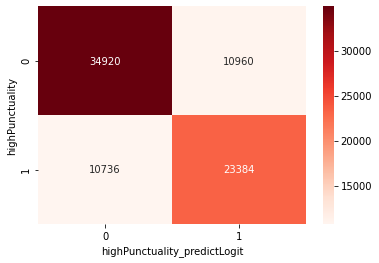

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

# drRatings = pd.concat([drRatings,TFIDF],axis=1)
ycol = 'highPunctuality'
x = drRatings[xcols]
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF.values],axis=1)
y = drRatings[ycol]

logit_model1 = sm.Logit(y, x)
logit_result = logit_model1.fit()

drRatings['highPunctuality_predictLogit'] = (logit_result.predict(x) >= 0.5).astype(int)
acc=metrics.accuracy_score(y_true=drRatings['highPunctuality'],y_pred=drRatings['highPunctuality_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings['highPunctuality'],y_pred=drRatings['highPunctuality_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("highPunctuality_predictLogit") 
plt.ylabel("highPunctuality") 

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

ycol = 'highPunctuality'
x = drRatings[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF.values],axis=1)
y = drRatings[ycol]


x_train=x[:10000]
x_test=x[10000:]
y_train=y[:10000]
y_test=y[10000:]
drRatings=drRatings.reset_index(drop=True)
drRatings_train=drRatings.loc[:9999]
drRatings_train=drRatings_train.reset_index(drop=True)
drRatings_test=drRatings.loc[10000:]
drRatings_test=drRatings_test.reset_index(drop=True)

logit_model1 = sm.Logit(y_train, x_train)
logit_result = logit_model1.fit()



Optimization terminated successfully.
         Current function value: 0.519960
         Iterations 7


prediction accuracy is 0.739


Text(33.0, 0.5, 'highPunctuality')

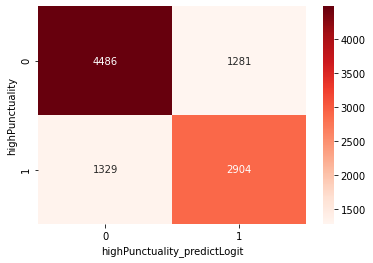

In [ ]:
drRatings_train['highPunctuality_predictLogit'] = (logit_result.predict(x_train) >= 0.5).astype(int).tolist()
acc=metrics.accuracy_score(y_true=drRatings_train['highPunctuality'],y_pred=drRatings_train['highPunctuality_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings_train['highPunctuality'],y_pred=drRatings_train['highPunctuality_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("highPunctuality_predictLogit") 
plt.ylabel("highPunctuality") 

prediction accuracy is 0.7164285714285714


Text(33.0, 0.5, 'highPunctuality')

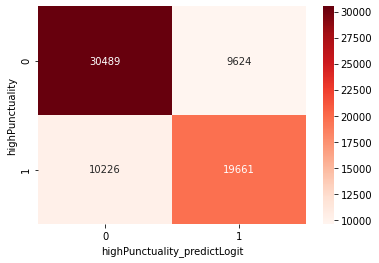

In [ ]:
drRatings_test['highPunctuality_predictLogit'] = (logit_result.predict(x_test) >= 0.5).astype(int)
acc=metrics.accuracy_score(y_true=drRatings_test['highPunctuality'],y_pred=drRatings_test['highPunctuality_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings_test['highPunctuality'],y_pred=drRatings_test['highPunctuality_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("highPunctuality_predictLogit")
plt.ylabel("highPunctuality")

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import seaborn as sn
drRatings = pd.read_excel('./OBGYN_new_train_80000.xlsx')
#shuffle the data so that they are in random sequence
drRatings = drRatings.sample(frac=1)
drRatings['highPunctuality'] = (drRatings['punctuality']>4).astype(int)

In [ ]:
testingdata = pd.read_excel('./OBGYN_new_test_lab_withAnswer_100.xlsx')

In [ ]:
temp = pd.get_dummies(drRatings['state'])
drRatings = pd.concat([drRatings,temp],axis=1)
del temp
drRatings['postedTime']=pd.to_datetime(drRatings['postedTime'])
drRatings['year']=drRatings['postedTime'].dt.year
drRatings['hour']=drRatings['postedTime'].dt.hour


In [ ]:
temp = pd.get_dummies(testingdata['state'])
testingdata = pd.concat([testingdata,temp],axis=1)
del temp
states=drRatings['state'].unique().tolist()
for state in states:
  if state not in testingdata.columns.tolist():
    testingdata[state]=[0]*testingdata.shape[0]
testingdata['postedTime']=pd.to_datetime(testingdata['postedTime'])
testingdata['year']=testingdata['postedTime'].dt.year
testingdata['hour']=testingdata['postedTime'].dt.hour


In [ ]:
import re
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess(text):
  text = text.lower() #lowercase
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ["dr", "doctor"]] #remove task specific stopwords
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
stop_words = ["dr", "doctor"] + list(stop_words)

def calTFIDF(texts,max_features=None):
  vectorizer = TfidfVectorizer(max_features=max_features,lowercase=True,stop_words=stop_words,ngram_range=(1,1))
  TFIDF = vectorizer.fit_transform(texts)
  TFIDF=pd.DataFrame(TFIDF.toarray(),columns=vectorizer.get_feature_names())
  return(TFIDF)


In [ ]:
drRatings['text'] = drRatings['review'].apply(lambda x:preprocess(x))
testingdata['text'] = testingdata['review'].apply(lambda x:preprocess(x))

In [ ]:
alltext=drRatings['text'].tolist()+testingdata['text'].tolist()

In [ ]:
TFIDF=calTFIDF(alltext,max_features=250)
TFIDF.columns = ['tfidf_'+x for x in TFIDF.columns]
TFIDF_train = TFIDF[:80000]
TFIDF_test = TFIDF[80000:]
TFIDF_test=TFIDF_test.reset_index(drop=True)
TFIDF

,tfidf_able,tfidf_absolutely,tfidf_actually,tfidf_ago,tfidf_amazing,tfidf_answer,tfidf_answered,tfidf_answers,tfidf_appointment,tfidf_appointments,tfidf_appt,tfidf_area,tfidf_ask,tfidf_asked,tfidf_away,tfidf_awesome,tfidf_babies,tfidf_baby,tfidf_bad,tfidf_bedside,tfidf_believe,tfidf_best,tfidf_better,tfidf_birth,tfidf_blood,tfidf_busy,tfidf_called,tfidf_calls,tfidf_came,tfidf_care,tfidf_cares,tfidf_caring,tfidf_check,tfidf_child,tfidf_children,tfidf_come,tfidf_comfortable,tfidf_compassionate,tfidf_completely,tfidf_complications,...,tfidf_think,tfidf_thorough,tfidf_thought,tfidf_time,tfidf_times,tfidf_told,tfidf_took,tfidf_treated,tfidf_treatment,tfidf_truly,tfidf_trust,tfidf_trying,tfidf_ultrasound,tfidf_understand,tfidf_understanding,tfidf_unprofessional,tfidf_use,tfidf_visit,tfidf_visits,tfidf_wait,tfidf_waited,tfidf_waiting,tfidf_want,tfidf_wanted,tfidf_wasnt,tfidf_way,tfidf_week,tfidf_weeks,tfidf_went,tfidf_wish,tfidf_woman,tfidf_women,tfidf_wonderful,tfidf_work,tfidf_worst,tfidf_worth,tfidf_wouldnt,tfidf_wrong,tfidf_year,tfidf_years
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.266048,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.177344,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.289824,0.0,0.0,0.000000,0.0,0.000000,0.233098,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.414001,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333607,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.288893,0.0,0.0,0.000000,0.351356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.304539,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.257127,0.0,0.0,0.000000,0.0,0.215683,0.30859,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.156025,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.230693,0.0,0.280661,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.446378,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.200039,0.0,0.000000,0.0,0.0,0.0,0.0,0.175159,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.228841,0.113004,0.0,0.164865,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.227593,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80095,0.000000,0.273373,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.303761,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.182735,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.184217,0.0,0.000000,0.00000,0.0,0.0,0.0,0.227894,0.0,0.0,0.0,...,0.0,

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

ycol = 'highPunctuality'
x = drRatings[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF_train.values],axis=1)
y = drRatings[ycol]


logit_model1 = sm.Logit(y, x)
logit_result = logit_model1.fit()


Optimization terminated successfully.
         Current function value: 0.528822
         Iterations 7


prediction accuracy is 0.7288125


Text(33.0, 0.5, 'highPunctuality')

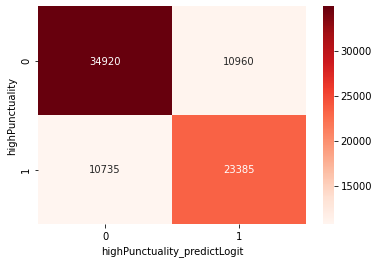

In [ ]:
drRatings['highPunctuality_predictLogit'] = (logit_result.predict(x) >= 0.5).astype(int)
acc=metrics.accuracy_score(y_true=drRatings['highPunctuality'],y_pred=drRatings['highPunctuality_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings['highPunctuality'],y_pred=drRatings['highPunctuality_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("highPunctuality_predictLogit") 
plt.ylabel("highPunctuality") 

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

x = testingdata[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF_test.values],axis=1)


pred = (logit_result.predict(x) >= 0.5).astype(int)
pred_prob = logit_result.predict(x)

In [ ]:
print(pred)
print(pred_prob)

[0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1
 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0]
[0.4239319  0.31929506 0.59724735 0.7773135  0.71006946 0.1596503
 0.0760966  0.88362733 0.40632752 0.53211419 0.04149215 0.25179362
 0.19448292 0.36066113 0.7201257  0.6249747  0.37696996 0.14534013
 0.29353085 0.06989602 0.78382538 0.85038337 0.31629774 0.32982601
 0.21774706 0.04563236 0.59255238 0.07042821 0.66475158 0.46263107
 0.66921493 0.20526042 0.60060898 0.46187571 0.87606132 0.30023729
 0.7940219  0.85915963 0.02461795 0.03155211 0.71193662 0.87298125
 0.69546662 0.0493192  0.87150527 0.11995799 0.72603876 0.11624447
 0.14314557 0.04152234 0.5483538  0.52449923 0.75377344 0.13425893
 0.82936509 0.2497036  0.86030719 0.07126142 0.85549929 0.59850916
 0.37258182 0.11566964 0.57941824 0.45054913 0.03001703 0.34376519
 0.67440691 0.22406817 0.61998906 0.10237465 0.47461098 0.72

In [ ]:
testingdata['highPunctuality'] = (testingdata['punctuality']>4).astype(int)
acc=metrics.accuracy_score(y_true=testingdata['highPunctuality'],y_pred=pred)
print(acc)
confusion=metrics.confusion_matrix(y_true=testingdata['highPunctuality'],y_pred=pred)
print(confusion)

0.72
[[42 13]
 [15 30]]
